In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
!python -m pip install --upgrade jax==0.2.10 jaxlib==0.1.62+cuda101 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
cd /mnt/home/tmakinen/repositories/scratch/gitinstall/imnn

In [3]:
!git checkout dev;

D	examples/2D sims - IMNN.ipynb
M	examples/IMNN - JAX.ipynb
Already on 'dev'
Your branch is ahead of 'origin/dev' by 3 commits.
  (use "git push" to publish your local commits)


In [8]:
!python -m pip install .

Already up-to-date.


In [6]:
pwd

'/mnt/home/tmakinen/repositories/scratch/dev-imnn/imnn'

In [11]:
!python -m setup.py install

/mnt/home/tmakinen/anaconda3/envs/pyjax/lib/python3.6/site-packages/setuptools/dist.py:458: UserWarning: Normalizing '0.3dev' to '0.3.dev0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
writing IMNN.egg-info/PKG-INFO
writing dependency_links to IMNN.egg-info/dependency_links.txt
writing requirements to IMNN.egg-info/requires.txt
writing top-level names to IMNN.egg-info/top_level.txt
reading manifest file 'IMNN.egg-info/SOURCES.txt'
writing manifest file 'IMNN.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying IMNN/experimental/jax/imnn/imnn.py -> build/lib/IMNN/experimental/jax/imnn
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/IMNN
creating build/bdist.linux-x86_64/egg/IMNN/LFI
copying build/lib/IMNN/LFI/LFI.py -> build/bdist.linux-x86_64/egg/IMNN/LFI
copying build/lib/IMNN/LFI/__init__.py -> build/bdist.linux-x86_64/egg/IMNN/LFI
copying b

In [3]:
!XLA_FLAGS=--xla_gpu_cuda_data_dir=/cm/shared/sw/pkg/devel/cuda/10.1.243_418.87.00
from jax.config import config
config.update("jax_debug_nans", True)
config.update('jax_enable_x64', True)


In [4]:
import itertools
import math
from functools import partial

import numpy as onp

import jax
print("jax version: ", jax.__version__)
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
from jax import jit
import matplotlib.pyplot as plt
import scipy

import imnn
print("IMNN version: ", imnn.__version__)

from imnn.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from imnn.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from imnn.utils import value_and_jacrev, value_and_jacfwd

rng = jax.random.PRNGKey(0)


jax version:  0.2.10
IMNN version:  0.3dev


In [5]:
!XLA_FLAGS=--xla_cpu_enable_fast_math=false

In [6]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


# Model in STAX

In [7]:
n_summaries = 2
n_s = 5000
n_d = 5000
λ = 100.0
ϵ = 0.1

In [8]:
# define inception block layer

def InceptBlock2(filters, strides, do_5x5=True, do_3x3=True):
    """InceptNet convolutional striding block.
    filters: tuple: (f1,f2,f3)
    filters1: for conv1x1
    filters2: for conv1x1,conv3x3
    filters3L for conv1x1,conv5x5"""
    
    filters1, filters2, filters3 = filters
    
    conv1x1 = stax.serial(stax.Conv(filters1, (1,1), strides, padding="SAME"))
    
    filters4 = filters2
    conv3x3 = stax.serial(stax.Conv(filters2, (1,1), strides=None, padding="SAME"),
                        stax.Conv(filters4, (3,3), strides, padding="SAME"))
                        
    filters5 = filters3
    conv5x5 = stax.serial(stax.Conv(filters3, (1,1), strides=None, padding="SAME"),
                         stax.Conv(filters5, (5,5), strides, padding="SAME"))
#     conv5x5 = stax.serial(stax.Conv(filters1, (1,1), strides=None, padding="SAME"),
#                          stax.Conv(filters3, (3,3), strides=None, padding="SAME"),
#                          stax.Conv(filters3, (3,3), strides, padding="SAME"))   
    
    maxpool = stax.serial(stax.MaxPool((3,3), padding="SAME"),
                         stax.Conv(filters4, (1,1), strides, padding="SAME"))
                            
    if do_3x3:
        if do_5x5:
            return stax.serial(
                  stax.FanOut(4),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, conv5x5, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
        else:
            return stax.serial(
                  stax.FanOut(3),  # should num=3 or 2 here ?
                  stax.parallel(conv1x1, conv3x3, maxpool),
                  stax.FanInConcat(), 
                  stax.LeakyRelu)
            
    else:
        return stax.serial(
              stax.FanOut(2),  # should num=3 or 2 here ?
              stax.parallel(conv1x1, maxpool),
              stax.FanInConcat(), 
              stax.LeakyRelu)
    
    
def Reshape(newshape):
    """Layer function for a reshape layer."""
    init_fun = lambda rng, input_shape: (newshape,())
    apply_fun = lambda params, inputs, **kwargs: np.reshape(inputs,newshape)
    return init_fun, apply_fun    


In [9]:
rng,drop_rng = jax.random.split(rng)
# fs = 4 #for 128x128 sims

# layers = []

# for i in range(7):
#     if i == 5:
#         layers.append(InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False)
#         )
#     elif i == 6:
#         layers.append(InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False)
#         )
#     else: 
#         layers.append(InceptBlock2((fs,fs,fs), strides=(2,2))
#         )
        
#     if i % 4 == 0:
#         fs *= 2
    
# layers.append(stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"))
# layers.append(stax.Flatten)

# model = stax.serial(*layers)

fs = 32
    
# model = stax.serial(InceptBlock((fs,fs,fs), strides=(2,2)), # output 64x64
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 32x32
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 16x16
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 8x8
#                     InceptBlock((fs,fs,fs), strides=(2,2)), # output 4x4
#                     InceptBlock((fs,fs,fs), strides=(2,2), do_5x5=False), # output 2x2
#                     InceptBlock((fs,fs,fs), strides=(2,2), do_5x5=False), # output 1x1
#                     stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
#                     stax.Flatten,
#                    )

model = stax.serial(
       # InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(4,4)),
        InceptBlock2((fs,fs,fs), strides=(2,2), do_5x5=False, do_3x3=False),
        stax.Conv(n_summaries, (1,1), strides=(1,1), padding="SAME"),
        stax.Flatten,
        Reshape((n_summaries,))
)

In [10]:
optimiser = optimizers.adam(step_size=1e-3)

In [8]:
# weights = model[0](rng, input_shape)[1]
# model[1](weights, np.zeros(input_shape, dtype=np.float32), rng=rng).shape
# state = optimiser[0](weights)
# model[1](optimiser[2](state), np.zeros(input_shape, dtype=np.float32), rng=rng)

# Random seeds for IMNN

In [11]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [12]:
rng, abc_key = jax.random.split(rng)

# 2D Gaussian Field Simulator in JAX

Steps to creating $(N \times N)$ 2D Gaussian field for IMNN:
1. Generate a $(N\times N)$ white noise field $\varphi$ such that $\langle \varphi_k \varphi_{-k} \rangle' = 1$
2. Fourier Transform $\varphi$ to real space: $R_{\rm white}(\textbf{x}) \rightarrow R_{\rm white}(\textbf{k})$
    - note: NumPy's DFT Fourier convention is:
    $$\phi_{ab}^{\textbf{k}} = \sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\textbf{x}}_{cd}}$$
    $$\phi_{ab}^{\textbf{x}} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) \phi^{\textbf{k}}_{cd}}$$    
3. Scale white noise $R_{\rm white}(\textbf{k})$ by the chosen power spectrum evaluated over a field of $k$ values:
$$ R_P(\textbf{k}) = P^{1/2}(k) R_{\rm white}(\textbf{k}) $$
    - note: here we need to ensure that this array of amplitudes is Hermitian, e.g. $\phi^{* \textbf{k}}_{a(N/2 + b)} = \phi^{\textbf{k}}_{a(N/2 - b)}$. This is accomplished by choosing indexes $k_a = k_b = \frac{2\pi}{N} (0, \dots, N/2, -N/2+1, \dots, -1)$ and then evaluating the square root of the outer product of the meshgrid between the two: $k = \sqrt{k^2_a + k^2_b}$. We can then evaluate $P^{1/2}(k)$.
    
4. Fourier Transform $R_{P}(\textbf{k})$ to real space: $ R_P(\textbf{x}) = \int d^d \tilde{k} e^{i\textbf{k} \cdot \textbf{x}} R_p(\textbf{k}) $:

$$R_{ab}^{\textbf{x}} = \frac{1}{N^2}\sum_{c,d = 0}^{N-1} \exp{(-i x_c k_a - i x_d k_b) R^{\textbf{k}}_{cd}}$$

In [13]:
# SET 32-BiT floats for model !
θ_fid = np.array([1.0, 0.5], dtype=np.float32)
δθ = np.array([0.1, 0.1], dtype=np.float32)
n_params = 2
N = 32
dim = 2
L = 32

field_shape = (N,N)
dx = L / N
fourier_b = 2*np.pi
input_shape = (1,1, N,N)
simulator_args = {"N": N, "L": L, "dim": dim, "shape": field_shape, 'vol_norm': False, "N_scale": True, "squeeze": False}

In [63]:
rng,fg_key = jax.random.split(rng)
foregrounds = jax.random.normal(fg_key, (1000, 1,) + simulator_args['shape'])*0


def default_P(k, A, B):
    return A*k**-B


class powerBoxJax:
    def __init__(self, shape, pk=None, k=None):
        
        if pk is None:
            self.pk = default_P
        else:
            self.pk = pk
            
        if k is None:
            self.k = np.sqrt(np.sum(np.array(np.meshgrid(*(
                (np.hstack((np.arange(0, _shape//2 + 1), 
                    np.arange(-_shape//2 + 1, 0))) * 2*np.pi / _shape)**2
                    for _shape in shape))), axis=0))
        else:
            self.k = k
            
        self.shape = shape
        self.N = shape[0]
        
    def simulator(self, rng, θ, simulator_args=simulator_args, add_foregrounds=False):
        def P(k, A=1, B=1):
            return self.pk(k, A, B)

        def fn(key, A, B):
            shape = self.shape #simulator_args["shape"]

            k = self.k

            new_shape = ()
            for _shape in shape:
                if _shape % 2 == 0:
                    new_shape += (_shape+1,)
                else:
                    new_shape += (_shape,)


            key1,key2 = jax.random.split(key)
    
            if add_foregrounds:
                foreground = foregrounds[jax.random.randint(key2, 
                                            minval=0, maxval=1000, shape=())]
            else:
                foreground = 0.

            # L is in length units, like Gpc
            L = simulator_args['L']
            dim = simulator_args['dim']

            if np.isscalar(L):
                L = [L]*int(dim)

            else:
                L = np.array(L)


            V = np.prod(np.array(L))

            scale = V**(1./dim)

            Lk = ()

            _N = 1
            for i,_shape in enumerate(shape):
                _N *= _shape
                Lk += (_shape / L[i],) # 1 / dx


            fft_norm = np.prod(np.array(Lk))

            _dims = len(shape)
            tpl = ()
            for _d in range(_dims):
                tpl += (_d,)

            # POWERBOX IMPLEMENTATION

            mag = jax.random.normal(key1, shape=tuple(N for N in new_shape))
            
            # random phases
            pha = 2 * np.pi * jax.random.uniform(key1, shape=tuple(N for N in new_shape))
            
            # now make hermitian field (reality condition)
            revidx = (slice(None, None, -1),) * len(mag.shape)
            mag = (mag + mag[revidx]) / np.sqrt(2) 
            pha = (pha - pha[revidx]) / 2 + np.pi
            dk = mag * (np.cos(pha) + 1j * np.sin(pha)) # output is complex

            cutidx = (slice(None, -1),) * len(new_shape)

            dk = dk[cutidx]
            powers = np.concatenate((np.zeros(1), 
                        np.sqrt(P(k.flatten()[1:], A=A, B=B)))).reshape(k.shape)

            # normalize power by volume
            if simulator_args['vol_norm']:
                powers = powers/V

            fourier_field = powers * dk

            fourier_field = jax.ops.index_update(
                fourier_field,
                np.zeros(len(shape), dtype=int),
                np.zeros((1,)))
            
            field = np.real(np.fft.ifftn(fourier_field) * fft_norm * V)
            
            if simulator_args["N_scale"]:
                field *= scale

            field = np.expand_dims(field + foreground, (0,))


            if not simulator_args["squeeze"]:
                field = np.expand_dims(field, (0,))

            return np.array(field, dtype='float32')

        shape = self.shape #simulator_args["shape"]
        A, B = θ


        if A.shape == B.shape:
            if len(A.shape) == 0:
                return fn(rng, A, B)
            else:
                keys = jax.random.split(rng, num=A.shape[0] + 1)
                rng = keys[0]
                keys = keys[1:]
                return jax.vmap(
                    lambda key, A, B: simulator(key, (A, B), simulator_args=simulator_args)
                )(keys, A, B)
        else:
            if len(A.shape) > 0:
                keys = jax.random.split(rng, num=A.shape[0] + 1)
                rng = keys[0]
                keys = keys[1:]
                return jax.vmap(
                    lambda key, A: simulator(key, (A, B), simulator_args=simulator_args)
                )(keys, A)
            elif len(B.shape) > 0:
                keys = jax.random.split(rng, num=B.shape[0])
                return jax.vmap(
                    lambda key, B: simulator(key, (A, B), simulator_args=simulator_args)
                )(keys, B)



    def AnalyticFisher(self, 
               θ, 
               kvec=None,
               N=None
              ):
        """
        Code for computing the Analytic Fisher for a Gaussian
        Field with power spectrum P(k) = Ak^-B
        """
        A,B = θ
        if N is None:
            N = self.N
        
        # we want all UNIQUE fourier modes
        if kvec is None:
            kvec = self.k[1:N//2, 1:N//2]

        pk = lambda k : A*(k**-B)             # P(k) = Ak^(-B)
        p_a = lambda k : k**-B                # deriv w.r.t. A
        p_b = lambda k : -A*(k**-B)*np.log(k) # deriv w.r.t. B


        powers = (pk(kvec.flatten()[:]))#np.concatenate((np.ones(1), 
            

        powera =  (p_a(kvec.flatten()[:])) #np.concatenate((np.zeros(1), 
           

        powerb = (p_b(kvec.flatten()[:])) #np.concatenate((np.zeros(1), 
            


        Cinv = np.diag(1. / powers)          # diagonal inv. covariance
        Ca =  np.diag(powera / 1.)           # C_{,A}
        Cb =  np.diag(powerb / 1.)           # C_{,B}

        Faa = 0.5 * np.trace((Ca @ Cinv @ Ca @ Cinv))
        Fab = 0.5 * np.trace((Ca @ Cinv @ Cb @ Cinv))
        Fba = 0.5 * np.trace((Cb @ Cinv @ Ca @ Cinv))
        Fbb = 0.5 * np.trace((Cb @ Cinv @ Cb @ Cinv))

        return np.array([[Faa, Fab], [Fba, Fbb]])



class analyticFieldLikelihood:

    def __init__(self,
                 PBJ, 
                 field_shape,
                 Δ,
                 prior,
                 k=None,
                 pk=None,
                 gridsize=20, 
                 tiling=2):

        """code for computing a gaussian field's likelihood for power spectrum parameters
            PBJ :         powerBox simulator object
            field_shape : list. shape of field input
            Δ :           array-like. FFT of the real-space field
            prior :       array-like. range over which to compute the likelihood
            k :           array-like. fourier modes over which to compute P(k)
            tiling :      list or int. tiling=2 means likelihood will be computed as 2x2 grid
            gridsize :    how large to make the likelihood surface
        """
        
        
        if k is None:
            self.k = PBJ.k

        if pk is None:
            self.pk = PBJ.pk

        self.field_shape = field_shape
        self.gridsize = gridsize
        if np.isscalar(tiling):
            self.tiling = [tiling]*2
        else:
            self.tiling = tiling    
        #self.tilesize = gridsize // tiling
        self.N = np.sqrt(np.prod(np.array(field_shape)))  # should just be N for NxN grid
        self.prior = prior

        self.k = k
        self.Δ = Δ

    def Pk(self, k, A=1, B=0.5):
        return self.pk(k, A, B)


        return np.diag(pk)
    def log_likelihood(self, k, A, B, Δ):
        Δ = Δ.flatten()[:]
        k = k

        dlength = len(k.flatten())

        def fn(_A, _B):

            nrm = np.pad(np.ones(dlength-2)*2, (1,1), constant_values=1.)
            nrm = jax.ops.index_update(
              nrm, np.array([[0],[(dlength-2)]]), np.array([[1],[1]]))
            nrm = 1

            powers = self.Pk(k.flatten()[:], A=_A, B=_B)

            # covariance is P(k)
            C = powers * nrm
            invC = 1./self.Pk(k.flatten()[:], A=_A, B=_B)

            logdetC = np.sum(np.log(C))
            pi2 = np.pi * 2.
            m_half_size = -0.5 * len(Δ)
            exponent = - 0.5 * np.sum(np.conj(Δ) * invC * Δ)
            norm = -0.5 * logdetC + m_half_size*np.log(pi2) 
            return (exponent + norm)
        return jax.vmap(fn)(A, B)

    def get_likelihood(self, return_grid=False, shift=None):
        A_start = self.prior[0][0]
        A_end = self.prior[1][0]
        B_start = self.prior[0][1]
        B_end = self.prior[1][1]

        region_size = [self.gridsize // self.tiling[i] for i in range(len(self.tiling))]

        print("computing likelihood on a %dx%d grid \n \
        in tiles of size %dx%d"%(self.gridsize, self.gridsize, region_size[0], region_size[1]))


        def get_like_region(A0, A1, B0, B1, qsize):
            A_range = np.linspace(A0, A1, qsize)
            B_range = np.linspace(B0, B1, qsize)
            A, B = np.meshgrid(A_range, B_range)

            return (self.log_likelihood(self.k,
                A.ravel(), B.ravel(), self.Δ).reshape(qsize,qsize))



        A_incr = (A_end - A_start) / self.tiling[0]
        B_incr = (B_end - B_start) / self.tiling[1]

        # marks the ends of linspace
        A_starts = [A_start + (i)*A_incr for i in range(self.tiling[0])]
        A_ends = [A_start + (i+1)*A_incr for i in range(self.tiling[0])]
        B_starts = [B_start + (i)*B_incr for i in range(self.tiling[1])]
        B_ends = [B_start + (i+1)*B_incr for i in range(self.tiling[1])]

        _like_cols = []
        for _col in range(self.tiling[0]):
            # slide horizontally in A
            _like_row = []
            for _row in range(self.tiling[1]):
                # slide vertically in B

                _like = get_like_region(A_starts[_row], 
                                        A_ends[_row], 
                                        B_starts[_col], 
                                        B_ends[_col],
                                        region_size[0],
                                        )
                _like_row.append(_like)

            _like_cols.append(np.concatenate(_like_row, axis=1))

        _log_likelihood = np.real(np.concatenate(_like_cols, axis=0))

        if shift is None:
            shift = np.max(_log_likelihood)

        print('shift', shift)
        print('loglike mean', np.mean(_log_likelihood))

        #_log_likelihood = _log_likelihood - shift

        if return_grid:
            _A_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            _B_range = np.linspace(self.prior[0,0], self.prior[1,0], self.gridsize)
            return (_log_likelihood), _A_range, _B_range

        return (_log_likelihood)



    def plot_contours(self, ax=None, 
                      θ_ref=None, shift=None, 
                      xlabel='A', ylabel='B', 
                      return_like=True):

        _like, _A, _B = self.get_likelihood(return_grid=True, shift=shift)


        _A, _B = np.meshgrid(_A, _B)

        if ax is None:
            fig,ax = plt.subplots(figsize=(10,10))

        mesh = ax.contourf(_A, _B, _like)
        plt.colorbar(mesh, ax=ax)

        if θ_ref is not None:
            ax.scatter(θ_ref[0], θ_ref[1], zorder=10, marker='+', s=100, color='r')

        ax.set_xlabel('A')
        ax.set_ylabel('B')

        if return_like:
            return _like, ax

        else:
            return ax
        

    def plot_corner(self, ax=None, θ_ref=None, label="Analytic likelihood", image_data=None):

        _like, _A_range, _B_range = self.get_likelihood(return_grid=True)

        likelihoodA = scipy.special.softmax(np.real(_like)).sum(0) #np.real(likelihood).sum(0)
        likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
        likelihoodB =  scipy.special.softmax(np.real(_like)).sum(1) #np.real(likelihood).sum(1)
        likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])

        _like = scipy.special.softmax(np.real(_like))
        sorted_marginal = np.sort(_like.flatten())[::-1]
        cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
        value = []
        for level in [0.997, 0.95, 0.68]:
            this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
            if len(value) == 0:
                value.append(this_value)
            elif this_value <= value[-1]:
                break
            else:
                value.append(this_value)

        if ax is None:
            fig,ax = plt.subplots(nrows=2, ncols=2)

        ax[1,0].contour(_A_range, _B_range, _like, levels=value, colors='C2', alpha=0.7)
        ax[0, 0].plot(_A_range, likelihoodA, color='C2', label=None, alpha=0.7)
        ax[1, 1].plot(likelihoodB, _B_range, color='C2', label='loglike', alpha=0.7)
        
        if image_data is not None:
            ax[0, 1].imshow(np.squeeze(image_data))
        else:
            ax[0, 1].axis("off")

        if θ_ref is not None:
            ax[0,0].axvline(θ_ref[0], linestyle='--', c='k')
            ax[1,0].axvline(θ_ref[0], linestyle='--', c='k')
            ax[1,0].axhline(θ_ref[1], linestyle='--', c='k')
            ax[1,1].axhline(θ_ref[1], linestyle='--', c='k', label=r'$\theta_{\rm ref}$')

        ax[1,0].set_xlabel(r'$A$')
        ax[1,0].set_ylabel(r'$B$')

        return ax



In [64]:
PBJ = powerBoxJax(simulator_args['shape'])
simulator = PBJ.simulator

## sim and gradient

In [65]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1, allow_int=True, holomorphic=True)(rng, θ, simulator_args=simulator_args)

In [66]:
rng, key = jax.random.split(rng)

In [67]:
field_shape

(32, 32)

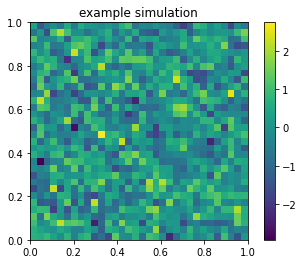

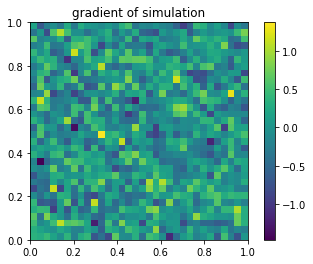

In [68]:
# plot example simulation and derivative
deriv_args = {"N": N, "L": 32, "dim": dim, "shape": field_shape, "vol_norm": True, "N_scale": True, "squeeze": False}
simulation, simulation_gradient = value_and_jacfwd(simulator, argnums=1)(rng, θ_fid, simulator_args=deriv_args)

plt.imshow(np.squeeze(simulation[0]), extent=(0,1,0,1))
plt.colorbar()
plt.title('example simulation')
plt.show()

plt.imshow(np.squeeze(simulation_gradient[0].T[0].T), extent=(0,1,0,1))
plt.title('gradient of simulation')
plt.colorbar()
plt.show()

In [69]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))


def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

# known analytic Fisher information

For a gaussian field, the likelihood is written
$$     \mathcal{L}(\Delta | \theta) = \frac{1}{(2\pi)^{N_p / 2} \det(C)^{1/2}}\exp{\left(-\frac{1}{2} \Delta C^{-1} \Delta \right)}$$

Where $\Delta \in \mathbb{R}^{N_p},\ N_p=N_k=V=N\times N$ is the Fourier Transform of the observed real-space field.
This yields a Fisher information matrix of

$$F_{\alpha \beta} = \langle -\frac{\partial^2 \ln \mathcal{L}}{\partial \lambda_\alpha \partial \lambda_\beta} \rangle= \frac{1}{2} {\rm Tr} (C_{, \alpha} C^{-1} C_{, \beta} C^{-1}) $$
where the covariance is
$$ C_{k_i, k_j} =  P(k_i)\delta_{ij}$$
The associated derivatives for a power law $P(k) = Ak^{-B}$ are
$$\begin{align}
    C_{,A} &= \left( k^{-B} \right)\delta_{ij} \\
    C_{,B} &= \left( -Ak^{-B}\ln k \right) \delta_{ij}
\end{align} $$

We notice that the Fisher information is *only* a function of the power spectrum parameters. It tells us the curvature of the chosen model (likelihood function) at a given $\theta$. The analytic Fisher information is the maximum amount of information we can expect the IMNN to extract from our simulations.


<!-- Alternatively, we can explore a volume integral analytically from the definition of C :
where the Fisher matrix is given by
$$ F_{\alpha \beta} = \sum_k \frac{1}{(\delta P_k)^2} \frac{\partial P_k}{\partial \lambda_\alpha} \frac{\partial P_k}{\partial \lambda_\beta}$$
and the error on $P_k$ is given (for a square, 2D box) as
$$ \delta P_k = \sqrt{\frac{2}{k (\Delta k) V} } \left( P_k + \frac{1}{\bar{n}} \right) $$ -->

<!-- For a gaussian field, the likelihood is written
$$ \ln \mathcal{L}(\theta | \vec{d}) = \ln \mathcal{L}(\theta | \Delta) = \sqrt{\frac{1}{2\pi C}} \exp{\frac{-{\Delta}^2}{2C}}$$

where $\vec{d} = \Delta$ is the overdensity field (in a cosmological context this is the measured temperature or galaxy count in a sky survey). Given that the power spectrum describes the correlations at different scales $k$, we can define the correlation via the power spectrum $C = P(k) = Ak^{-B}$ to compute the log-likelihood. The Fisher information matrix, given as 
$$ F_{\alpha \beta} = \langle - \frac{\partial^2 \ln \mathcal{L}}{\partial \theta_\alpha \partial \theta_\beta} \rangle $$
can then be computed analytically for our likelihood:
$$ F_{\alpha \beta} = \sum_k \frac{1}{(\delta P_k)^2} \frac{\partial P_k}{\partial \theta_\alpha} \frac{\partial P_k}{\partial \theta_\beta} $$

where $\delta P_k = \sqrt{\frac{2}{4\pi \Delta k V k_{\rm tot}^2}} (P_k + \frac{1}{\bar{n}})$ is the error on $P_k$ with survey volume $V$, sampling interval $\Delta k$, and shot noise $1/\bar{n}$. Using the fact that $d\ln P_k = \frac{d P_k}{P_k}$, we can rewrite the sum as an integral:
$$ F_{\alpha \beta} = 2 \pi \left( \frac{V_{\rm eff}}{\lambda^3} \right) \int_{k_{\rm min}}^{k_{\rm max}} d \ln k  \frac{\partial \ln P_k}{\partial \theta_\alpha} \frac{\partial \ln P_k}{\partial \theta_\beta}$$

Where $V_{\rm eff}$ and $\lambda^3$ are our effective windowed survey size and survey extent, respectively (set to 1 for now). Doing the integration explicitly, we obtain the Fisher matrix for parameters $\theta = (A, B)$:
$$ F = 2 \pi \left( \frac{V_{\rm eff}}{\lambda^3} \right) \begin{bmatrix}
    \frac{1}{A^2} \ln (\frac{k_{\rm max}}{k_{\rm min}}) & \frac{1}{2A} ((\ln k_{\rm min})^2 - (\ln k_{\rm max})^2)  \\
     \frac{1}{2A} ((\ln k_{\rm min})^2 - (\ln k_{\rm max})^2) & \frac{1}{3}((\ln k_{\rm max})^3 - (\ln k_{\rm min})^3)   \\
\end{bmatrix}$$
 -->


For our fiducial model with our data vector of size $128^2$, our $\rm det|F|$ reads:

In [70]:
N = simulator_args["N"]
shape = simulator_args["shape"]

kbin = np.sqrt(np.sum(np.array(np.meshgrid(*(
    np.hstack((np.arange(0, _shape//2 + 1), 
        np.arange(-_shape//2 + 1, 0))) *2* np.pi / _shape
        for _shape in shape)))**2, axis=0))

f_expected = PBJ.AnalyticFisher(θ_fid, kvec=None)
print("analytic F(θ_fid): ", f_expected)

detf_expected = np.linalg.det(f_expected)
print("analytic det(F(θ_fid)): ", detf_expected)

analytic F(θ_fid):  [[112.5        -88.08135241]
 [-88.08135241  92.25651195]]
analytic det(F(θ_fid)):  2620.5329515016588


In [71]:
# MAKE SIMULATION
N = simulator_args["N"]
shape = (N,N)

θ_sim = np.array([0.7, 0.8])
simulator_args = {"N": N, "L": 32, "dim": dim, "shape": shape, "vol_norm": True, "N_scale": False, "squeeze": True}
simulator_args["shape"] = (N,N)
simkey,rng = jax.random.split(rng)
#sim = np.squeeze(target_data)#
sim = np.squeeze(simulator(simkey, θ_sim, simulator_args=simulator_args))
sim_fft = (np.fft.fft2(sim)) #/ (N**2)

In [72]:
gridsize = 100                # for likelihood gridding
Δ = sim_fft[1:N//2, 1:N//2]
k = kbin[1:N//2, 1:N//2]  
prior_range = np.array([[0.1, 0.1], [1.25, 1.25]])
AL = analyticFieldLikelihood(PBJ, shape, Δ, prior_range, k=k, gridsize=gridsize, tiling=[5,5])

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -214.13729373238735
loglike mean -257.6307697783974


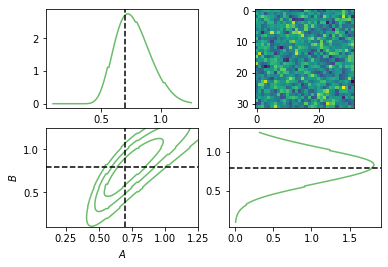

In [75]:
#plt.style.use('default')
ax = AL.plot_corner(θ_ref=θ_sim, image_data=sim)

In [ ]:
simulator_args

In [45]:
likes = []
likeAs = []
likeBs = []
rng1 = jax.random.PRNGKey(13)
values = []
θ_target = np.array([0.8, 0.8], dtype=np.float32)

for t in range(20):
    key, rng1 = jax.random.split(rng1)
    targ = simulator(
        key,
        θ_target)
    
    gridsize = 50                # for likelihood gridding
    Δ = np.fft.fftn(np.squeeze(targ))[1:N//2, 1:N//2] / N
    k = kbin[1:N//2, 1:N//2]  
    prior_range = np.array([[0.1, 0.1], [1.25, 1.25]])
    AL = analyticFieldLikelihood(PBJ, shape, Δ, prior_range, k=k, 
                                 gridsize=gridsize, tiling=[5,5])

    likelihood,A_range,B_range = AL.get_likelihood(shift=None, return_grid=True)
    
    
    _A_range = A_range#*np.exp(shift)
    _B_range = B_range#*np.exp(shift)

    likelihoodA = scipy.special.softmax(np.real(likelihood)).sum(0) #np.real(likelihood).sum(0)
    likelihoodA /= likelihoodA.sum() * (_A_range[1] -  _A_range[0])
    likelihoodB =  scipy.special.softmax(np.real(likelihood)).sum(1) #np.real(likelihood).sum(1)
    likelihoodB /= likelihoodB.sum() * (_B_range[1] -  _B_range[0])
        
    likelihood = scipy.special.softmax(np.real(likelihood))
    sorted_marginal = np.sort(likelihood.flatten())[::-1]
    cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
    value = []
    for level in [0.997, 0.95, 0.68]:
        this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
        if len(value) == 0:
            value.append(this_value)
        elif this_value <= value[-1]:
            break
        else:
            value.append(this_value)
    #fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    
    #likelihood /= likelihood.sum()
    
    likes.append(likelihood)
    likeAs.append(likelihoodA)
    likeBs.append(likelihoodB)
    
    values.append(value)

computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -226.65323
loglike mean -281.2912
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -222.269
loglike mean -273.09332
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -224.88367
loglike mean -276.536
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -235.14114
loglike mean -294.90643
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -211.05551
loglike mean -256.40872
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -202.47757
loglike mean -243.11711
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -225.42264
loglike mean -278.68454
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -238.12628
loglike mean -301.53705
computing likelihood on a 50x50 grid 
         in tiles of size 10x10
shift -199.5029
loglike mean -237.86707
computi

Text(0, 0.5, '$B$')

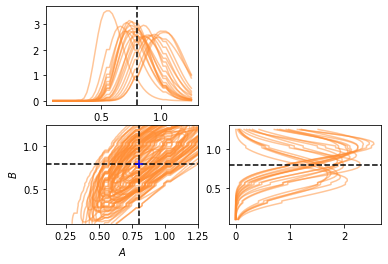

In [46]:
fig,ax = plt.subplots(nrows=2, ncols=2)

for l,like in enumerate(likes):
    ax[1,0].contour(A_range, B_range, like, levels=value, colors='#FF8D33', alpha=0.5)
    ax[0, 0].plot(A_range, likeAs[l], color='#FF8D33', label=None, alpha=0.5)
    ax[0, 1].axis("off")
    ax[1, 1].plot(likeBs[l], B_range, color='#FF8D33', label='loglike', alpha=0.5)
    
ax[1,0].scatter(θ_target[0], θ_target[1], marker='+', s=50, color='blue', zorder=20)
ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

# Initialise IMNN

In [60]:
from imnn.imnn._imnn import _IMNN
from imnn.utils.utils import _check_simulator #, value_and_jacrev
from imnn.utils.utils import _check_simulator

class SimIMNN(_IMNN):
    def __init__(self, n_s, n_d, n_params, n_summaries, input_shape, θ_fid,
                 model, optimiser, key_or_state, simulator):
        super().__init__(
            n_s=n_s,
            n_d=n_d,
            n_params=n_params,
            n_summaries=n_summaries,
            input_shape=input_shape,
            θ_fid=θ_fid,
            model=model,
            key_or_state=key_or_state,
            optimiser=optimiser,
            )
        self.simulator = _check_simulator(simulator)
        self.simulate = True

    def get_fitting_keys(self, rng):
        return jax.random.split(rng, num=3)

    def get_summaries(self, w, key, validate=False):
        def get_summary(key, θ):
            return self.model(w, self.simulator(key, θ))

        def get_derivatives(key):
            return value_and_jacrev(get_summary, argnums=1)(key, self.θ_fid)

        keys = np.array(jax.random.split(key, num=self.n_s))
        summaries, derivatives = jax.vmap(get_derivatives)(keys[:self.n_d])
        if self.n_s > self.n_d:
            summaries = np.vstack([
                summaries,
                jax.vmap(partial(get_summary, θ=self.θ_fid))(keys[self.n_d:])])
        return np.squeeze(summaries), np.squeeze(derivatives)
    
    

In [64]:
simulator_args["squeeze"] = False

In [65]:
simulator_args['vol_norm'] = True
simulator_args['N_scale'] = True # false 
simulator_args['L'] = 32.0

In [66]:
simulator_args

{'N': 32,
 'L': 32.0,
 'dim': 2,
 'shape': (32, 32),
 'vol_norm': True,
 'N_scale': True,
 'squeeze': False}

In [73]:
IMNN = SimulatorIMNN(
        n_s=5000,
        n_d=5000,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        model=model,
        optimiser=optimiser,
        key_or_state=initial_model_key,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
#         devices=[jax.devices()[0]],
#         n_per_device=1000
        )

# Fit

In [35]:
# new_optimiser = jax.experimental.optimizers.sgd(1e-5)
# weights = np.load('./model/best_w.npy',  allow_pickle=True)
# IMNN.opt_initialiser, IMNN.update, IMNN.get_parameters = optimiser
# IMNN.state = IMNN.opt_initialiser(list(weights))

In [30]:
# SAVING IMNN ATTRIBUTES
import cloudpickle as pickle
import os

def save_weights(IMNN, folder_name='./model', weights='final'):
    
    # create output directory
    if not os.path.exists(folder_name): 
        os.mkdir(folder_name)
    
    def pckl_me(obj, path):
        with open(path, 'wb') as file_pi:
            pickle.dump(obj, file_pi)
        file_pi.close()
        
    # save IMNN (optimiser) state:
    savestate = jax.experimental.optimizers.unpack_optimizer_state(IMNN.state)
    pckl_me(savestate, os.path.join(folder_name, 'IMNN_state'))
    
    # save weights
    if weights == 'final':
        np.save(os.path.join(folder_name, 'final_w'), IMNN.final_w)
    
    else:
        np.save(os.path.join(folder_name, 'best_w'), IMNN.best_w)
        
    # save initial weights
    np.save(os.path.join(folder_name, 'initial_w'), IMNN.initial_w)
        
    # save training history
    pckl_me(IMNN.history, os.path.join(folder_name, 'history'))
    
    # save important attributes as a dict
    imnn_attributes = {
        'n_s': IMNN.n_s,
        'n_d': IMNN.n_d,
        'input_shape': IMNN.input_shape,
        'n_params' : IMNN.n_params,            
        'n_summaries': IMNN.n_summaries,
        'θ_fid': IMNN.θ_fid,
        'F': IMNN.F,   
        'validate': IMNN.validate,
        'simulate': IMNN.simulate,
        
    }
    
    pckl_me(imnn_attributes, os.path.join(folder_name, 'IMNN_attributes'))
    
    print('saved weights and attributes to the file ', folder_name)
    
    
def load_weights(IMNN, folder_name='./model', weights='final', load_attributes=True):
    
    
    def unpckl_me(path):
        file = open(path, 'rb')
        return pickle.load(file)
    
    # load and assign weights
    if weights=='final':
        weights = np.load(os.path.join(folder_name, 'final_w.npy'),  allow_pickle=True)
        IMNN.final_w = weights
    else:
        weights = np.load(os.path.join(folder_name, 'best_w.npy'),  allow_pickle=True)
        IMNN.best_w = weights
        
    # re-pack and load the optimiser state
    loadstate = unpckl_me(os.path.join(folder_name, 'IMNN_state'))
    IMNN.state = jax.experimental.optimizers.pack_optimizer_state(loadstate)
    
    
    # load history
    IMNN.history = unpckl_me(os.path.join(folder_name, 'history'))
    
    # load important attributes
    if load_attributes:
        IMNN.intial_w =  np.load(os.path.join(folder_name, 'initial_w.npy'), allow_pickle=True)
        attributes = unpckl_me(os.path.join('test_model', 'IMNN_attributes'))
        IMNN.θ_fid = attributes['θ_fid']
        IMNN.n_s = attributes['n_s']
        IMNN.n_d = attributes['n_d']
        IMNN.input_shape = attributes['input_shape']
        
    print('loaded IMNN with these attributes: ', attributes)
    

In [37]:
# # test save functions
# save_weights(IMNN, folder_name='./model')

# # test load functions

# # initialize a new imnn with different attributes and then load the old file
# # to overwrite them

# my_new_IMNN = SimIMNN(
#         n_s=300,
#         n_d=100,
#         n_params=n_params,
#         n_summaries=n_summaries,
#         input_shape=input_shape,
#         θ_fid=np.array([1.0,1.0]),
#         key=initial_model_key,
#         model=model,
#         optimiser=optimiser,
#         simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
#         )

# load_weights(my_new_IMNN, folder_name='./model', load_attributes=True)
# my_new_IMNN.set_F_statistics(rng, my_new_IMNN.best_w, my_new_IMNN.θ_fid, my_new_IMNN.n_s, my_new_IMNN.n_d, validate=True)

In [68]:
IMNN_rngs = 1 * [fitting_key] #+ 12 * [None]
labels = [
    "Simulator, InceptNet\n"
]

In [69]:
θ_fid

DeviceArray([1. , 0.5], dtype=float32)

In [70]:
%%time
for i in range(1):
    rng,fit_rng = jax.random.split(rng)
    IMNN.fit(λ=10., ϵ=ϵ, rng=fit_rng, min_iterations=500) #for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs);
    
#save_weights(IMNN, folder_name='./big_incept128')

NameError: name 'IMNN' is not defined

In [82]:
IMNNs = [IMNN]

In [83]:
for i, (IMNN, label) in enumerate(zip(IMNNs, labels)):
    if i == 0:
        ax = imnn.training_plot(expected_detF=detf_expected, colour="C{}".format(i), label=label)
    elif i == 10:
        other_ax = imnn.training_plot(
            expected_detF=detf_expected, colour="C{}".format(i), label=label
        )
    elif i == 11:
        imnn.training_plot(
            ax=other_ax,
            expected_detF=50, colour="C{}".format(i), label=label
        )
        other_ax[0].set_yscale("log")
        other_ax[2].set_yscale("log")
    else:
        IMNN.training_plot(
            ax=ax, expected_detF=None, colour="C{}".format(i), label=label, ncol=5
        );
ax[0].set_yscale("log")

AttributeError: module 'imnn' has no attribute 'training_plot'

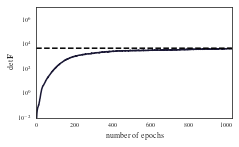

In [84]:
latexify(fig_width=3.37)
plt.plot(IMNN.history['detF'][:])
plt.plot(np.ones(len(IMNN.history['detF'][:]))*detf_expected, c='k', linestyle='--')
plt.ylim(1e-2, 1e7)
plt.ylabel(r'$\det \textbf{F}$')
plt.xlabel('number of epochs')
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-training.png', dpi=400)

In [85]:
np.linalg.det(IMNNs[0].F) #/ (detf_expected)

DeviceArray(4280.8877, dtype=float32)

In [86]:
IMNNs[0].F

Buffer([[ 159.41925, -119.76941],
        [-119.76941,  116.83406]], dtype=float32)

In [87]:
print('IMNN F:', IMNN.F)

print('IMNN det F:', np.linalg.det(IMNN.F))

print('IMNN F / analytic det F: ', (np.linalg.det(IMNN.F)) / detf_expected)

IMNN F: [[ 159.41925 -119.76941]
 [-119.76941  116.83406]]
IMNN det F: 4280.8877
IMNN F / analytic det F:  0.9360231527357517


# Data for ABC example

In [88]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = np.array(jax.random.split(
            seed, 
            num=len(self.event_shape)))
        return jax.vmap(
            lambda key, low, high : jax.random.uniform(
                key, 
                shape=(n,), 
                minval=low, 
                maxval=high))(
            keys, self.low, self.high)


In [89]:
prior = uniform([0.1, 0.1], [1.25, 1.25])

In [90]:
simulator_args

{'N': 32,
 'L': 32.0,
 'dim': 2,
 'shape': (32, 32),
 'vol_norm': True,
 'N_scale': True,
 'squeeze': False}

In [127]:
simulator_args = {"N": N, "L": 32, "dim": dim, "shape": shape, "N_scale": True, "vol_norm": True, "squeeze": True}

rng, key = jax.random.split(rng)
θ_target = np.array([0.8, 0.8])
target_data = simulator(
    key,
    θ_target,
    simulator_args={**simulator_args, **{'squeeze':False}})

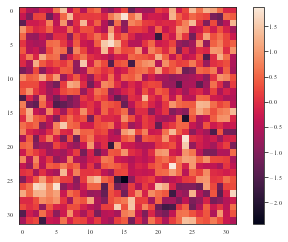

In [128]:
%matplotlib inline
plt.imshow(np.squeeze(target_data))
plt.colorbar()

# analytic likelihood calculation

In [129]:
gridsize = 100                # for likelihood gridding
Δ = np.fft.fftn(np.squeeze(target_data))[:N//2, :N//2] / N
k = kbin[:N//2, :N//2]  
prior_range = np.array([[0.1, 0.1], [1.25, 1.25]])
AL = analyticFieldLikelihood(PBJ, shape, Δ, prior_range, k=k, gridsize=gridsize, tiling=[5,5])

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -334.61356055313496
loglike mean -382.4315989879251
CPU times: user 1.03 s, sys: 82.7 ms, total: 1.12 s
Wall time: 964 ms


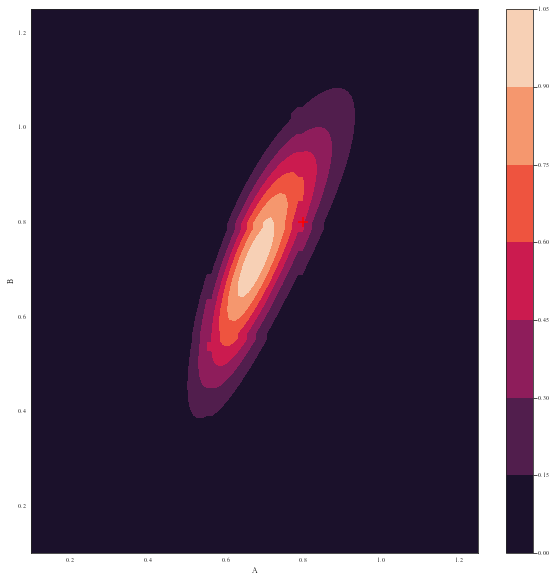

In [130]:
%%time
%matplotlib inline
#plt.style.use('default')
likelihood,_ = AL.plot_contours(θ_ref=θ_target, shift=None, xlabel=r'$A$', ylabel=r'$B$', return_like=True)

# Gaussian approximation

In [131]:
@jit #partial(jax.jit, static_argnums=0)
def get_estimate(d):
    if len(d.shape) == 1:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,l->i",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)
    else:
        return IMNN.θ_fid + np.einsum(
            "ij,kj,kl,ml->mi",
            IMNN.invF,
            IMNN.dμ_dθ,
            IMNN.invC,
            IMNN.model(IMNN.best_w, d, rng=rng) - IMNN.μ)

In [132]:
estimates = get_estimate(target_data) #[i.get_estimate(target_data) for i in IMNNs];

In [133]:
detf_expected

DeviceArray(4573.48483614, dtype=float64)

In [134]:
GAs = [GaussianApproximation(get_estimate(target_data), IMNN.invF, prior)]
       #GaussianApproximation(get_estimate(target_data), np.linalg.inv(f_expected), prior)]

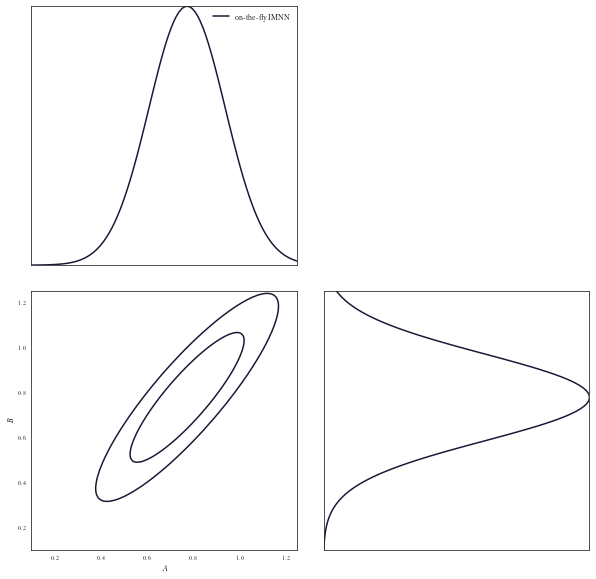

In [135]:
%matplotlib inline
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$A$", r"$B$"], label='on-the-fly IMNN', colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

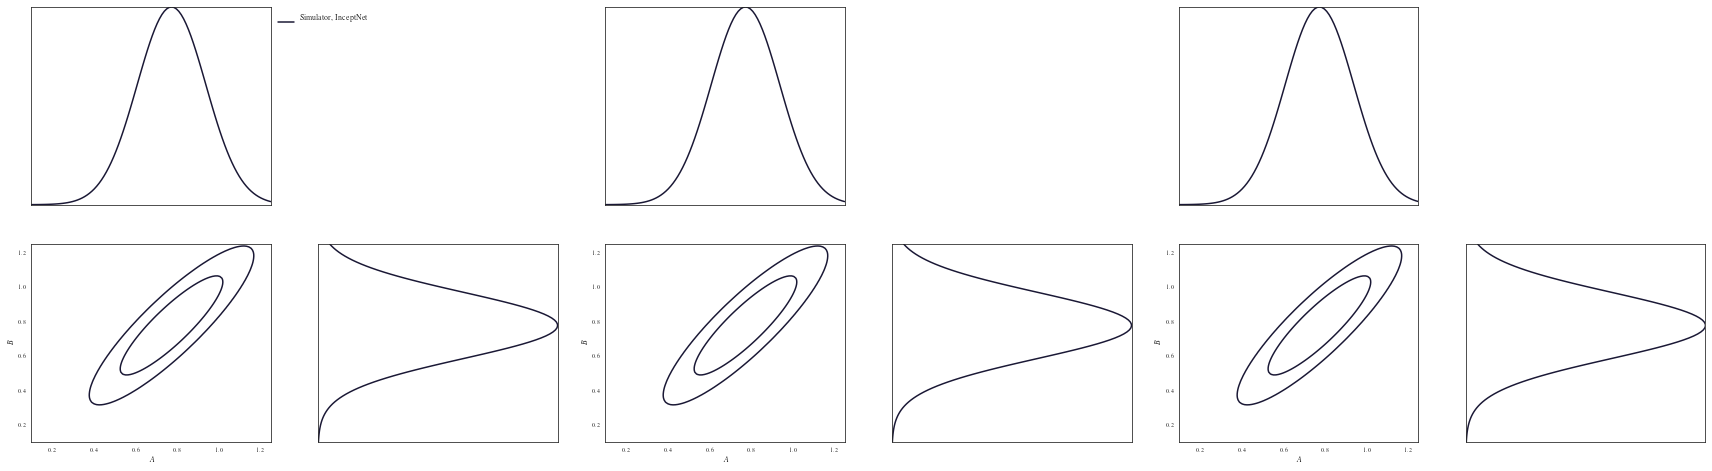

In [136]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax1 = GA.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$A$", r"$B$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = GA.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$A$", r"$B$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = GA.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$A$", r"$B$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        GA.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        GA.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        GA.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

# ABC

In [137]:
{**simulator_args, **{'squeeze':True}}

{'N': 32,
 'L': 32,
 'dim': 2,
 'shape': (32, 32),
 'N_scale': True,
 'vol_norm': True,
 'squeeze': True}

In [138]:
ABC = ApproximateBayesianComputation(
        target_data, prior, 
     lambda A,B : simulator(A,B, simulator_args={**simulator_args, **{'squeeze':True}}), 
                                       get_estimate, F=IMNN.F, gridsize=50
    )

In [139]:
%%time
rng,abc_key = jax.random.split(rng)
ABC(rng=abc_key,
        n_samples=int(1e3),
        min_accepted=15000,
        max_iterations=20000,
        ϵ=0.05,
        smoothing=0.);

1918 accepted in last  20000 iterations  (20000000 simulations done).
CPU times: user 34.9 s, sys: 1.42 s, total: 36.4 s
Wall time: 38 s


(<imnn.utils.container.container at 0x154b9cc3e1c0>,
 <imnn.utils.container.container at 0x154b9cb436d0>)

In [116]:
ABC.parameters.accepted[0].shape

(3733, 2)

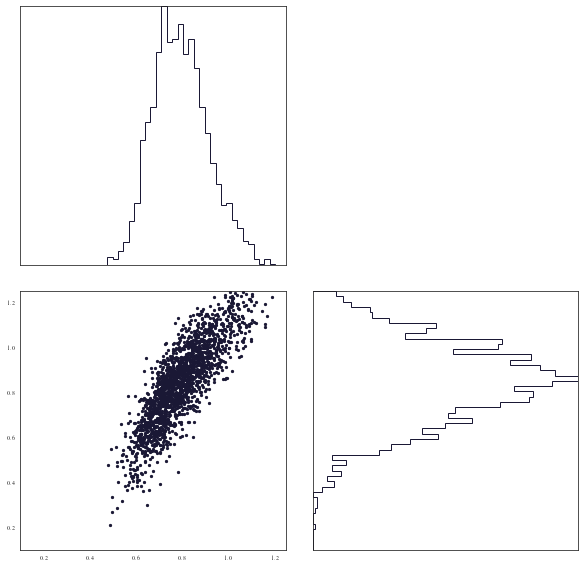

In [140]:
#ax = ABC.scatter_plot(points=ABC.parameters.rejected, colours='red')
ax = ABC.scatter_plot()

In [110]:
#np.save("accepted.npy", ABC.parameters.accepted)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

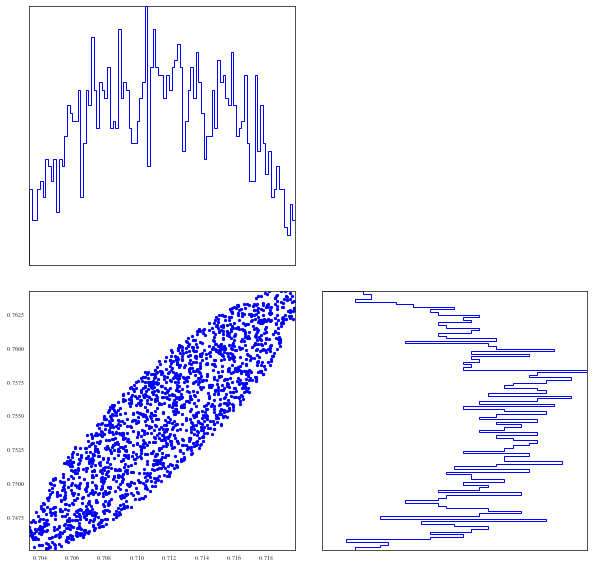

In [111]:
#ax = ABC.scatter_summaries(points=ABC.summaries.rejected, colours='red')
ABC.scatter_summaries( colours='blue')

In [141]:
likelihood,A_range,B_range = AL.get_likelihood(return_grid=True)

computing likelihood on a 100x100 grid 
         in tiles of size 20x20
shift -334.61356055313496
loglike mean -382.4315989879251


In [142]:
#A_range = np.linspace(0.1, 3.0, 25)
#B_range = np.linspace(0.1, 2.5, 25)
likelihoodA = np.real(likelihood).sum(0)
likelihoodA /= likelihoodA.sum() * (A_range[1] -  A_range[0])
likelihoodB = np.real(likelihood).sum(1)
likelihoodB /= likelihoodB.sum() * (B_range[1] -  B_range[0])
sorted_marginal = np.sort(np.real(likelihood).flatten())[::-1]
cdf = np.cumsum(sorted_marginal / sorted_marginal.sum())
value = []
for level in [0.95, 0.68]:
    this_value = sorted_marginal[np.argmin(np.abs(cdf - level))]
    if len(value) == 0:
        value.append(this_value)
    elif this_value <= value[-1]:
        break
    else:
        value.append(this_value)
#fig, ax = plt.subplots(2, 2, figsize=(10, 10))


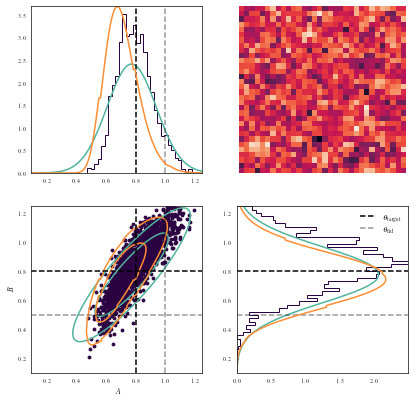

In [143]:
%matplotlib inline
#plt.style.use('default')
new_colors = [ '#2c0342', '#286d87', '#4fb49d', '#9af486']
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(3.37*2, 3.37*2))
latexify(fig_width=3.37, fig_height=3.37)

ABC.scatter_plot(ax=ax,
                      colours=new_colors[0], 
                      axis_labels=[r"$A$", r"$B$"], 
                      s=8,
                      label='ABC estimate')
# ABC.marginal_plot(ax=ax,
#             axis_labels=[r"$A$", r"$B$"], colours='green',
#             label='ABC marginal plot')


GAs[0].marginal_plot(ax=ax, colours=new_colors[2], axis_labels=[r"$A$", r"$B$"], label=None, ncol=1)
ax[0,1].imshow(target_data[0, 0])

#ax[0,1].set_title(r'$\theta_{\rm target} = A,B = (%.2f,%.2f)$'%(θ_target[0], θ_target[1]))

ax[0,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axvline(θ_target[0], linestyle='--', c='k')
ax[1,0].axhline(θ_target[1], linestyle='--', c='k')
ax[1,1].axhline(θ_target[1], linestyle='--', c='k', label=r'$\theta_{\rm target}$')

ax[1,0].set_xlabel(r'$A$')
ax[1,0].set_ylabel(r'$B$')

ax[0,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
#ax[1,0].contourf(A_range, B_range, L1.reshape((size, size)))
#ax[0, 0].plot(A_range, np.real(loglikeA), color='g', label='loglikeA')

ax[1,0].axvline(θ_fid[0], linestyle='--', c='k', alpha=0.4)
ax[1,0].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4)
ax[1,1].axhline(θ_fid[1], linestyle='--', c='k', alpha=0.4, label=r'$\theta_{\rm fid}$')

ax[1,1].legend(framealpha=0.)


# add in the likelihood estimate
ax[0, 0].plot(A_range, likelihoodA, color='#FF8D33', label=None)
ax[0, 1].axis("off")
ax[1, 0].contour(A_range, B_range, np.real(likelihood), levels=value, colors='#FF8D33')
ax[1, 1].plot(likelihoodB, B_range, color='#FF8D33', label='loglike')

ax[0,0].legend(framealpha=0.)

#plt.savefig('/mnt/home/tmakinen/repositories/field-plots/128x128-contours.png', dpi=400)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [116]:
# do PMC-ABC
import tensorflow_probability
tfp = tensorflow_probability.experimental.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

In [143]:
def new_ABC(rng, n_points, proposal_distribution, simulator, data_summary, f, n_parallel_simulations=None, simulator_parameters=None):
    def get_distance(summaries, data_summary, f):
        if len(data_summary.shape) > 1:
            return jax.vmap(lambda data_summary, f : get_distance(summaries, data_summary, f))(data_summary, f)
        if len(summaries.shape) == 1:
            difference = summaries - data_summary
            distance = difference.dot(f).dot(difference)
            return jax.lax.cond(np.isnan(distance), lambda _ : np.inf, lambda distance : distance, distance)
        elif len(summaries.shape) == 2:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-1)(summaries)
        else:
            return jax.vmap(lambda summaries : get_distance(summaries, data_summary, f), out_axes=-2)(summaries)
    shape = (n_points,)
    if n_parallel_simulations is not None:
        shape = shape + (n_parallel_simulations,)
    rng, key = jax.random.split(rng)
    proposed = proposal_distribution.sample(shape, seed=key)
    key = jax.random.split(rng, num=np.prod(np.array(proposed).shape[:-1]))
    summaries = simulator(key.reshape(proposed.shape[:-1] + (2,)), proposed, simulator_parameters=simulator_parameters)
    distances = get_distance(summaries, data_summary, f)
    return proposed, summaries, distances

In [144]:
def w_cov(proposed, weighting):
    weighted_samples = proposed * weighting[:, np.newaxis]
    return weighted_samples.T.dot(weighted_samples) / weighting.T.dot(weighting)

In [145]:
class tmvn():
    def __init__(self, loc, scale, low, high, max_counter=int(1e3)):
        self.loc = loc
        self.scale = scale
        self.low = low
        self.high = high
        if len(loc.shape) > 1:
            self.n_samples = loc.shape[0]
        else:
            self.n_samples = None
        self.n_params = low.shape[0]
        self.max_counter = max_counter

    def mvn(self, rng, loc):
        u = jax.random.normal(rng, shape=(self.n_params,))
        return loc + u.dot(self.scale)

    def w_cond(self, args):
        _, loc, counter = args
        return np.logical_and(
            np.logical_or(
                np.any(np.greater(loc, self.high)),
                np.any(np.less(loc, self.low))),
            np.less(counter, self.max_counter))

    def __sample(self, args):
        rng, loc, counter = args
        rng, key = jax.random.split(rng)
        return (rng, self.mvn(key, loc), counter+1)

    def _sample(self, rng, loc):
        rng, key = jax.random.split(rng)
        _, loc, counter = jax.lax.while_loop(
            self.w_cond, 
            self.__sample, 
            (rng, self.mvn(key, loc), 0))
        return jax.lax.cond(
            np.greater_equal(counter, self.max_counter),
            lambda _ : np.nan * np.ones((self.n_params,)),
            lambda _ : loc,
            None)

    def _sample_n(self, rng, loc, n=None):
        if n is None:
            return self._sample(rng, loc)
        else:
            key = jax.random.split(rng, num=n)
            return jax.vmap(self._sample)(key, 
                np.repeat(loc[np.newaxis], n, axis=0))

    def sample(self, shape=None, seed=None):
        if shape is None:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc)
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc))(key, self.loc)
        elif len(shape) == 1:
            if self.n_samples is None:
                return self._sample_n(seed, self.loc, n=shape[0])
            else:
                key = jax.random.split(seed, num_self.n_samples)
                return jax.vmap(lambda key, loc : self._sample_n(key, loc, n=shape[0]))(key, self.loc)
        else:
            key = jax.random.split(seed, num=shape[-1])
            return jax.vmap(lambda key: self.sample(shape=tuple(shape[:-1]), seed=key), out_axes=-2)(key)

In [146]:
def PMC(rng, n_initial_points, n_points, prior, simulator, data_summary, f, percentile=75, acceptance_ratio=0.1, 
        max_iteration=10, max_acceptance=10, max_samples=int(1e3), n_parallel_simulations=None, simulator_parameters=None):
    low = np.array([dist.low for dist in prior.distributions])
    high = np.array([dist.high for dist in prior.distributions])
    def single_PMC(rng, samples, summaries, distances, weighting, data_summary, f):
        def single_iteration_condition(args):
            return np.logical_and(
                np.greater(args[-3], acceptance_ratio),
                np.less(args[-2], max_iteration))
        def single_iteration(args):
            def single_acceptance_condition(args):
                return np.logical_and(
                    np.less(args[-2], 1),
                    np.less(args[-1], max_acceptance))
            def single_acceptance(args):
                rng, loc, summ, dist, draws, accepted, acceptance_counter = args
                #rng, loc, summ, dist, draws, rejected, acceptance_counter = args
                rng, key = jax.random.split(rng)
                proposed, summaries, distances = new_ABC(
                    key, None, tmvn(loc, scale, low, high, max_counter=max_samples),
                    simulator, data_summary, f, n_parallel_simulations=n_parallel_simulations,
                    simulator_parameters=simulator_parameters)
                if n_parallel_simulations is not None:
                    min_distance_index = np.argmin(distances)
                    min_distance = distances[min_distance_index]
                    closer = np.less(min_distance, ϵ)
                    loc = jax.lax.cond(closer, lambda _ : proposed[min_distance_index], lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries[min_distance_index], lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances[min_distance_index], lambda _ : dist, None)
                    iteration_draws = n_parallel_simulations - np.isinf(distances).sum()
                    draws += iteration_draws 
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                else:
                    closer = np.less(distances, dist)
                    loc = jax.lax.cond(closer, lambda _ : proposed, lambda _ : loc, None)
                    summ = jax.lax.cond(closer, lambda _ : summaries, lambda _ : summ, None)
                    dist = jax.lax.cond(closer, lambda _ : distances, lambda _ : dist, None)
                    iteration_draws = 1 - np.isinf(distances).sum()
                    draws += iteration_draws
                    accepted = closer.sum()
                    #rejected = iteration_draws - closer.sum()
                return (rng, loc, summ, dist, draws, accepted, acceptance_counter+1)
                #return (rng, loc, summ, dist, draws, rejected, acceptance_counter+1)

            rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws = args
            ϵ = distances[ϵ_ind]
            loc = samples[ϵ_ind:]
            cov = w_cov(samples, weighting)
            inv_cov = np.linalg.inv(cov)
            scale = np.linalg.cholesky(cov)
            rng, *key = jax.random.split(rng, num=loc.shape[0]+1)
            draws = np.zeros(loc.shape[0], dtype=np.int32)
            accepted = np.zeros(loc.shape[0], dtype=np.int32)
            #rejected = np.zeros(loc.shape[0], dtype=np.int32)
            acceptance_counter = np.zeros(loc.shape[0], dtype=np.int32)

            results = jax.vmap(
                lambda key, loc, summaries, distances, draws, accepted, acceptance_counter : jax.lax.while_loop(
                #lambda key, loc, summaries, distances, draws, rejected, acceptance_counter : jax.lax.while_loop(
                    single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, accepted, acceptance_counter)))(
                    #single_acceptance_condition, single_acceptance, (key, loc, summaries, distances, draws, rejected, acceptance_counter)))(
                np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, accepted, acceptance_counter)
                #np.array(key), loc, summaries[ϵ_ind:], distances[ϵ_ind:], draws, rejected, acceptance_counter)

            weighting = jax.vmap(
                lambda proposed : (
                    prior.prob(proposed) 
                    / (np.sum(weighting * tfd.MultivariateNormalTriL(
                        loc=samples,
                        scale_tril=np.repeat(
                            scale[np.newaxis], 
                            samples.shape[0], 
                            axis=0)).prob(proposed)))))(
                    np.vstack([samples[:ϵ_ind], results[1]]))
            samples = jax.ops.index_update(samples, jax.ops.index[ϵ_ind:, :], results[1])
            summaries = jax.ops.index_update(summaries, jax.ops.index[ϵ_ind:, :], results[2])
            distances = jax.ops.index_update(distances, jax.ops.index[ϵ_ind:], results[3])
            acceptance_reached = results[-2].sum() / results[-3].sum()
            return (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter+1, total_draws+results[-3].sum())

        acceptance_reached = np.inf
        iteration_counter = 0
        total_draws = 0
        results = jax.lax.while_loop(
            single_iteration_condition, 
            single_iteration, 
            (rng, samples, summaries, distances, weighting, data_summary, f, acceptance_reached, iteration_counter, total_draws))
        return results[1], results[2], results[3], results[4], results[7], results[8], results[9]

    rng, key = jax.random.split(rng)
    proposed, summaries, distances = new_ABC(
        key, n_initial_points, prior, simulator, data_summary, f, 
        n_parallel_simulations=n_parallel_simulations, simulator_parameters=simulator_parameters)

    if n_parallel_simulations is not None:
        proposed = proposed.reshape((n_initial_points * n_parallel_simulations, -1))
        summaries = summaries.reshape((n_initial_points * n_parallel_simulations, -1))
        if len(data_summary.shape) > 1:
            distances = distances.reshape((data_summary.shape[0], -1))
        else:
            distances = distances.reshape((-1,))

    if len(data_summary.shape) == 1:
        sample_indices = np.argsort(distances)[:n_points]
        samples = proposed[sample_indices]
        summaries = summaries[sample_indices]
        distances = distances[sample_indices]
    else:
        sample_indices = np.argsort(distances, axis=1)[:, :n_points]
        samples = jax.vmap(lambda x: proposed[x])(sample_indices)
        summaries = jax.vmap(lambda x: summaries[x])(sample_indices)
        distances = np.take_along_axis(distances, sample_indices, axis=1)    

    weighting = prior.prob(samples)

    if percentile is None:
        ϵ_ind = -1
        to_accept = 1
    else:
        ϵ_ind = int(percentile / 100 * n_points)
        to_accept = n_points - ϵ_ind

    if len(data_summary.shape) == 1:
        return single_PMC(rng, samples, summaries, distances, weighting, data_summary, f)
    else:
        key = jax.random.split(rng, num=data_summary.shape[0])
        return jax.vmap(single_PMC)(key, samples, summaries, distances, weighting, data_summary, f)

In [147]:
targe_data_summary = get_estimate(target_data)

In [148]:
low = np.array([0.1, 0.1])
high = np.array([2., 2.])
myprior = tfd.Blockwise([tfd.Uniform(low=low[i], high=high[i]) for i in range(low.shape[0])])

In [149]:
rng, key = jax.random.split(rng)
ppmc_prop, ppmc_summ, ppmc_dist, ppmc_w, ppmc_crit, ppmc_it, ppmc_draws = PMC(
    rng=key, n_initial_points=1000, n_points=250, prior=myprior, simulator=simulator, 
    data_summary=targe_data_summary, f=IMNN.F, percentile=75, acceptance_ratio=0.5, 
    max_iteration=int(1e2), max_acceptance=int(1e3), max_samples=int(1e3), 
    n_parallel_simulations=100, simulator_parameters=(low, high, input_shape))

TypeError: prod requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

In [1]:
# Create figures in Python that handle LaTeX, and save images to files in my
# preferred formatting. I typically place this code in the root of each of my
# projects, and import using:
# from latexify import *
# which will also run the latexify() function on the import.

# Based on code from https://nipunbatra.github.io/blog/2014/latexify.html

import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

#Back-end to use depends on the system
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
# matplotlib.use('pgf')
# from matplotlib.backends.backend_pgf import FigureCanvasPgf
# matplotlib.backend_bases.register_backend('ps', FigureCanvasPgf)

import seaborn as sns
sns.set_style("white")

#my preferred palette. From
#https://seaborn.pydata.org/tutorial/color_palettes.html: "The cubehelix color
#palette system makes sequential palettes with a linear increase or decrease in
#brightness and some variation in hue. This means that the information in your
#colormap will be preserved when converted to black and white (for printing) or
#when viewed by a colorblind individual."

# I typically set the number of colors (below, 8) to the distinct colors I need
# in a given plot, so as to use the full range.
sns.set_palette(sns.color_palette("cubehelix", 8))


# The following is the latexify function. It allows you to create 2 column or 1
# column figures. You may also wish to alter the height or width of the figure.
# The default settings are good for most cases. You may also change the
# parameters such as labelsize and fontsize based on your classfile.
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1, 2])

    if fig_width is None:
        fig_width = 6.9 if columns == 1 else 13.8  # width in inches #3.39

    if fig_height is None:
        golden_mean = (sqrt(5) - 1.0) / 2.0    # Aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    MAX_HEIGHT_INCHES = 16.0
    if fig_height > MAX_HEIGHT_INCHES:
        print(("WARNING: fig_height too large:" + fig_height +
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches."))
        fig_height = MAX_HEIGHT_INCHES

    params = {
            # 'backend': 'ps',
           #   'pgf.rcfonts': False,
           #   'pgf.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
           #   "pgf.texsystem": "pdflatex",
             # 'text.latex.preamble': ['\\usepackage{gensymb}', '\\usepackage[dvipsnames]{xcolor}'],
              'text.latex.preamble': '\\usepackage{mathptmx}',
              #values below are useful defaults. individual plot fontsizes are
              #modified as necessary.
              'axes.labelsize': 8,  # fontsize for x and y labels
              'axes.titlesize': 8,
              'font.size': 8,
              'legend.fontsize': 8,
              'xtick.labelsize': 6,
              'ytick.labelsize': 6,
              'text.usetex': True,
              'figure.figsize': [fig_width, fig_height],
              'font.family': 'serif',
              'font.serif': 'Times',
               'lines.linewidth': 1.5,
               'lines.markersize':1,
               'xtick.major.pad' : 2,
               'ytick.major.pad' : 2,
                'axes.xmargin' :  .0,  # x margin.  See `axes.Axes.margins`
                'axes.ymargin' : .0,  # y margin See `axes.Axes.margins`
              }

    matplotlib.rcParams.update(params)

def saveimage(name, fig = plt, extension = 'pdf', folder = 'plots/'):
    sns.despine()

    #Minor ticks off by default in matplotlib
    # plt.minorticks_off()

    #grid being off is the default for seaborn white style, so not needed.
    # plt.grid(False, axis = "x")
    # plt.grid(False, axis = "y")
    
    fig.savefig('{}{}.{}'.format(folder,name, extension), bbox_inches = 'tight')

latexify()

In [75]:
!python -m pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
     |████████████████████████████████| 9.7 MB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 139.4 MB/s eta 0:00:01
